# Point Estimator Using Gradient Descent

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import patsy
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.cross_validation import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
from sklearn.linear_model import (LinearRegression, LogisticRegression, 
                                  Lasso, Ridge,
                                  SGDRegressor, SGDClassifier)


%matplotlib inline
plt.style.use('fivethirtyeight')

## Load the Batting Player Trianing Table

In [2]:
master_df = pd.read_csv("batting_player_training_dataset.csv")

In [3]:
def turn_to_float(val):
    #print val
    fl = float(val)
    return fl

def turn_to_int(val):
    #print val
    try:
        i = int(val)
    except:
        return val
    return i

def format_batter_numeric_rows(df):
    
    h = df.columns
    
    for i in np.arange(1, len(h), 1):
        
        try:
            df.loc[:, h[i]] = df[h[i]].map(turn_to_float)
        except:
            #print h[i]
            df.loc[:, h[i]] = df[h[i]]
            
    return df
def get_log_data(gamelogs_url, year, player):
    
    #url = 'http://www.baseball-reference.com/players/gl.cgi?id=crawfbr01&t=b&year=2015'
    url = gamelogs_url
    #print url
    r = requests.get(url)
    #    print "got to site"
    b = BeautifulSoup(r.text, 'html.parser')
    HTML = r.text 

    #Initialize row identifier
    RK = 1
    end_of_table = False
    
    #print gamelogs_url
    
    headers = [''.join(td.xpath('.//text()').extract()) for td in Selector(text=HTML).xpath('//div[3]/table/thead/tr/th')]
    
    #print len(headers)
    
    if len(headers) == 50:
        #It's a pitcher!
        log_data = pd.DataFrame(columns=headers)
        #print log_data.columns
        
    else:

        #Declare a new instance of a Dataframe log
        #It's a batter!
        log_data = pd.DataFrame(columns=headers)
#         log_data = pd.DataFrame(columns=(
#             'RK', 'Gcar', 'Gtm', 'Date', 'Tm', 'HoA', 'Opp', 'Rslt',
#            'Inngs', 'PA', 'AB', 'R', 'H', 'Doubles', 'Tripples', 'HR',
#            'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP',
#            'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'BOP', 'aLI', 'WPA',
#            'RE24', 'DK', 'FD', 'Pos')
#         )
    
    exception_cases = []

    #While RK is not null (i.e at the end of the table...)
    #increment RK and collect pitching totals
    while(end_of_table == False):

        #//div[3]/table/tbody/tr[1]/td
        #Gate Keeping code to determine if while loop should proceed
        try: 
            fields = [''.join(td.xpath('.//text()').extract()) for td in Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK)+']/td')]
            #fields = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK)+']/td/text()').extract()
            ahrefs = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK)+']/td/a').extract()
            row_number = fields[0].encode('utf-8').strip()
            #print len(fields)
            
        except:
            try:
                #Is this because we have encoutered a "title" row? As opposed to end of table?
                fields = [''.join(td.xpath('.//text()').extract()) for td in Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK+1)+']/td')]
                #fields = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK+1)+']/td/text()').extract()
                ahrefs = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK+1)+']/td/a').extract()
                row_number = fields[0].encode('utf-8').strip()

                RK += 1
            except:
                #We have reached the end of the table
                end_of_table = True
                #print year, RK, len(fields)
                

                
        #print year, row_number, len(fields), len(ahrefs)
        #Check if this year game log table contains data for DK and DF
        if len(fields) == 38:     #Table has DK, and FD information
            log_data.loc[row_number, "Year"] = year
            log_data.loc[row_number, "name"] = player
            log_data.loc[row_number, "ptype"] = "batter"
            log_data.loc[row_number, "Rk"] = row_number
            
            for i in np.arange(1, len(fields), 1):
                    
                    h = headers[i].encode('utf-8').strip()
                    log_data.loc[row_number, h] = fields[i].encode('utf-8').strip()
            
        #If no data for DK and DF, enter columns and assign null values
        elif len(fields) == 36:
            log_data.loc[row_number, "Year"] = year
            log_data.loc[row_number, "name"] = player
            log_data.loc[row_number, "ptype"] = "batter"
            log_data.loc[row_number, "RK"] = row_number
            log_data.loc[row_number, "DFS(DK)"] = ""
            log_data.loc[row_number, "DFS(FD)"] = ""
            
            for i in np.arange(1, len(fields), 1):
                    
                    h = headers[i].encode('utf-8').strip()
                    log_data.loc[row_number, h] = fields[i].encode('utf-8').strip()
        
        #From visual instection, pitcher game log tables tend to have 50 columns.  A good follow-up step would be to
        #figure this out in a more systematic way.
        elif len(fields) == 50:
            
            log_data.loc[row_number, "Year"] = year
            log_data.loc[row_number, "name"] = player
            log_data.loc[row_number, "ptype"] = "pitcher"
            log_data.loc[row_number, "Rk"] = row_number
            
            for i in np.arange(1, len(fields), 1):
                    
                    h = headers[i].encode('utf-8').strip()
                    log_data.loc[row_number, h] = fields[i].encode('utf-8').strip()
            
        else:
            exception_cases.append(RK)
            
        
        RK += 1
    
    return log_data

#get_log_data("http://www.baseball-reference.com/players/gl.cgi?id=abadfe01&t=p&year=2016", 2016)

def get_training_data(player):
    
    #Load the player dictionary table containing player URL extensions
    player_index = pd.read_csv("/Users/carlosbeas/sfdat26-beas/Capstone/Capstone_MLB/Data/player_index.csv")
    row_of_interest = (player_index.name == player)
    if len(row_of_interest) == 0:
        #Player was not found
        print "Error:  Player does not exist"
        empty_df = pd.DataFrame()
        return empty_df
    else:
        #Follow the URL extension found in the "links" field of the data frame
        #print player_index[row_of_interest].links
        index_of_interest = player_index[row_of_interest].index
        #print index_of_interest[0]
        extension = player_index.iloc[index_of_interest[0]]["links"]
        extension = str(extension)
        #print extension
        player_url = "http://www.baseball-reference.com"+extension
        #print player_url
        #Follow the URL and extract the additional data needed
        r = requests.get(player_url)
        #    print "got to site"
        b = BeautifulSoup(r.text, 'html.parser')
        HTML = r.text
        
        #xpath for Gamelogs:  //div[2]/div[4]/ul/li/a
        try:
            fields = Selector(text=HTML).xpath('//div[2]/div[4]/ul/li/a').extract()
            gamelogs_url = fields[2].encode('utf-8').strip()

        except:
            #fields = Selector(text=HTML).xpath('//div[5]/div[2]/div[2]/ul/li/a')
            gamelogs_url = re.search('<a href="(\/players\/gl.*)">Game Logs', HTML).group(1)
            #print gamelogs_url
        
        #years_of_interest
        years_of_interest = np.arange(2011, 2016, 1)
        years_of_interest = sorted(years_of_interest, reverse=True)
        
        player_log = pd.DataFrame()
        buffer_df = pd.DataFrame()

        for year in years_of_interest:
            
            url = "http://www.baseball-reference.com"+gamelogs_url + str(year)
            #print url
            try:

                buffer_df = get_log_data(url, year, player)
                player_log = player_log.append(buffer_df)

            except:
                #We have found a year log that does not exist for this player and it is likely that the preceeding years
                #also do not exist...
                print "ERROR:  This is not an active player."
                buffer_df = pd.DataFrame()
                break
        
    return player_log

#There is no data collected for DFS (DK and FD) for years 2012 and earlier.
#Creating a function that masks the dataframe to only look at data that has this information
def select_DFS_rows(df):
    
    DFS_years = (df.Year > 2012)
    DFS_df = df[DFS_years]
    
    return DFS_df

def calculate_rolling_means(glog):
    rol_means = pd.DataFrame()
    
    if glog.ptype[0] == "batter":
        
        #Ensure values of interest in dataframe are numeric
        #Since feature extraction analysis has not been run 
        #for pitcher, defaulting to two common features that are equally as important for pitcher
        glog.WPA = glog.WPA.map(turn_to_float)
        glog.RE24 = glog.RE24.map(turn_to_float)
        glog.RBI = glog.RBI.map(turn_to_float)
        glog.H = glog.H.map(turn_to_float)
        glog.HR = glog.HR.map(turn_to_float)
        
        #Calculate rolling mean for batter features
        RE24 = glog['RE24']
        RE24 = (RE24 - RE24.mean()) / RE24.std()
        RE24_rollmean = RE24.rolling(window=10).mean()
        rol_means["RE24"] = RE24_rollmean

        WPA = glog['WPA']
        WPA = (WPA - WPA.mean()) / WPA.std()
        WPA_rollmean = WPA.rolling(window=10).mean()
        rol_means["WPA"] = WPA_rollmean

        RBI = glog['RBI']
        RBI = (RBI - RBI.mean()) / RBI.std()
        RBI_rollmean = RBI.rolling(window=10).mean()
        rol_means["RBI"] = RBI_rollmean

        H = glog['H']
        H = (H - H.mean()) / H.std()
        H_rollmean = H.rolling(window=10).mean()
        rol_means["H"] = H_rollmean

        HR = glog['HR']
        HR = (HR - HR.mean()) / HR.std()
        HR_rollmean = HR.rolling(window=10).mean()
        rol_means["HR"] = HR_rollmean
        
        rol_means["player"] = glog.name[0]
    
    if glog.ptype[0] == "pitcher":
        
        #Ensure values of interest in dataframe are numeric
        #Since feature extraction analysis has not been run 
        #for pitcher, defaulting to two common features that are equally as important for pitcher
        glog.WPA = glog.WPA.map(turn_to_float)
        glog.RE24 = glog.RE24.map(turn_to_float)
        #Calculate rolling mean for pitcher features
        
        RE24 = glog['RE24']
        RE24 = (RE24 - RE24.mean()) / RE24.std()
        RE24_rollmean = RE24.rolling(window=10).mean()
        rol_means["RE24"] = RE24_rollmean

        WPA = glog['WPA']
        WPA = (WPA - WPA.mean()) / WPA.std()
        WPA_rollmean = WPA.rolling(window=10).mean()
        rol_means["WPA"] = WPA_rollmean
        
        rol_means["player"] = glog.name[0]

    
    return rol_means

def get_rolling_mean(player):
    
    today = dt.datetime.today().strftime("%m/%d/%Y")
    today = today.split("/")
    this_month = today[0]
    this_day = today[1]
    this_year = today[2]
    
    
    #Load the player dictionary table containing player URL extensions
    player_index = pd.read_csv("/Users/carlosbeas/sfdat26-beas/Capstone/Capstone_MLB/Data/player_index.csv")
    row_of_interest = (player_index.name == player)
    if len(row_of_interest) == 0:
        #Player was not found
        print "Error:  Player does not exist"
        empty_df = pd.DataFrame()
        return empty_df
    else:
        #Follow the URL extension found in the "links" field of the data frame
        #print player_index[row_of_interest].links
        index_of_interest = player_index[row_of_interest].index
        #print index_of_interest[0]
        extension = player_index.iloc[index_of_interest[0]]["links"]
        extension = str(extension)
        #print extension
        player_url = "http://www.baseball-reference.com"+extension
        #print player_url
        #Follow the URL and extract the additional data needed
        r = requests.get(player_url)
        #    print "got to site"
        b = BeautifulSoup(r.text, 'html.parser')
        HTML = r.text
        
        #xpath for Gamelogs:  //div[2]/div[4]/ul/li/a
        try:
            fields = Selector(text=HTML).xpath('//div[2]/div[4]/ul/li/a').extract()
            gamelogs_url = fields[2].encode('utf-8').strip()

        except:
            #fields = Selector(text=HTML).xpath('//div[5]/div[2]/div[2]/ul/li/a')
            gamelogs_url = re.search('<a href="(\/players\/gl.*)">Game Logs', HTML).group(1)
            #print gamelogs_url
            
        url = "http://www.baseball-reference.com"+gamelogs_url + str(this_year)
        
        #print url
        try:

            game_log = get_log_data(url, this_year, player)

        except:
            #We have found a year log that does not exist for this player and it is likely that the preceeding years
            #also do not exist...
            print "ERROR:  This is not an active player."
            empty_df = pd.DataFrame()
            return empty_df
        
        #print game_log.shape
        
        my_rolling_mean = pd.DataFrame()
        months = []
        days = []
    
        #gameday = game_log.Date.map(lambda x: x.split())
        for i in np.arange(0, game_log.shape[0], 1):
            gameday = game_log.Date[i]
            gameday = str(gameday)
            month = re.search('(\w+)', gameday).group(1)
            #print month
            day = re.search('(\d+)', gameday).group(1)
            #print day
            months.append(month)
            days.append(day)
    #       print day
            
        #print months
        game_log["toDate"] = game_log["Year"] + "-" + months + "-" + days
        #print game_log["toDate"]
        game_log.toDate = pd.to_datetime(game_log.toDate)
        game_log.set_index('toDate', inplace=True)
        
        #get rolling mean of features for player
        my_rolling_mean = calculate_rolling_means(game_log)
        my_rolling_mean = my_rolling_mean.iloc[-1]
        
    return my_rolling_mean



In [4]:
#Limit the table to only years of interest
master_df = select_DFS_rows(master_df)

#Identify the players stored in the dataframe
my_players = master_df.name.unique()

In [5]:
master_df = format_batter_numeric_rows(master_df)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3964 entries, 0 to 5958
Data columns (total 43 columns):
Unnamed: 0    3964 non-null int64
Unnamed: 1    2012 non-null object
2B            3964 non-null float64
3B            3964 non-null float64
AB            3964 non-null float64
BA            3960 non-null float64
BB            3964 non-null float64
BOP           3964 non-null float64
CS            3964 non-null float64
DFS(DK)       3964 non-null float64
DFS(FD)       3964 non-null float64
Date          3964 non-null object
GDP           3942 non-null float64
Gcar          3964 non-null float64
Gtm           3964 non-null object
H             3964 non-null float64
HBP           3964 non-null float64
HR            3964 non-null float64
IBB           3942 non-null float64
Inngs         3964 non-null object
OBP           3960 non-null float64
OPS           3960 non-null float64
Opp           3964 non-null object
PA            3964 non-null float64
Pos           3964 non-null object
R

In [7]:
master_df.drop("RK", axis=1, inplace=True)
rename_map = {
    # Original column: [renamed column]
    '2B': 'doubles',
    '3B': 'tripples',
    'DFS(DK)': 'DK',
    'DFS(FD)': 'FD'
}

master_df.rename(columns=rename_map, inplace=True)

## Run Gridsearch on Stochastic Gradient Descent

In [9]:
sgd_params = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=2)

In [11]:
player = "Jacoby Ellsbury"
    
player_mask = (master_df.name == player)
player_df = master_df[player_mask]

#Define my target and features
y, X = patsy.dmatrices('DK ~ RE24+WPA+H+HR+RBI', data=player_df, return_type="dataframe")
y = np.ravel(y)

sgd_reg_gs.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.6s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    1.2s


[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] .

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    3.4s


[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.1s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] .

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    7.6s


[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] .

[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed:   14.2s


[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] p

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   21.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [15]:
## Print best estimator, best parameters, and best score
sgd_best = sgd_reg_gs.best_estimator_
print "best estimator", sgd_best
print "\n==========\n"
print "best parameters", sgd_reg_gs.best_params_
print "\n==========\n"
print "best score", sgd_reg_gs.best_score_

 best estimator SGDRegressor(alpha=0.01, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)


best parameters {'penalty': 'l2', 'alpha': 0.01, 'loss': 'squared_loss'}


best score 0.781475327799


In [16]:
# check the RMSE for a Random Forest that only includes important features
scores = cross_val_score(sgd_best, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

3.4843092968544802

Cross Validated Scores:  [ 0.64967355  0.89275884  0.72758164  0.87563037  0.77114001  0.86625139
  0.8337499   0.5972326   0.69907904  0.80340632]
Average Score:  0.771650366154


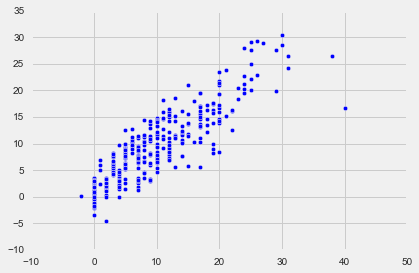

In [17]:
sgd_Score = cross_val_score(sgd_best, X, y, cv=10)
print "Cross Validated Scores: ", sgd_Score
print "Average Score: ", np.mean(sgd_Score)

# # Make cross validated predictions
predictions = cross_val_predict(sgd_best, X, y, cv=10)
plt.scatter(y, predictions)

- Stochastic Gradient Descent is showing significant improvement in accuracy over Random Forest.
    - When using "Jacoby Ellsbury” as player for model performance evaluation:
        - Random Forest predicts DFS with an RMSE of 3.854270 and R2 of 0.727957

        - SGD predicts DFS with an RMSE of
3.4843092968544802 and R2 of
0.78147
    - That’s an improvement of ~7.3% on R2 and 9.59% on RMSE